In [1]:
import pandas as pd

## Load the test data

In [3]:
gameData = pd.read_csv('/Users/Amogh/Documents/GitHub Repositories/Kaggle-MobileGame-AB-Testing/cookie_cats.csv')
gameData.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
gameData.shape

(90189, 5)

## Check missing values

In [6]:
gameData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## Count the number of players in each group

In [7]:
gameData.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The number of players is roughly the same in the control and test group

## Analyzing Player Behavior 

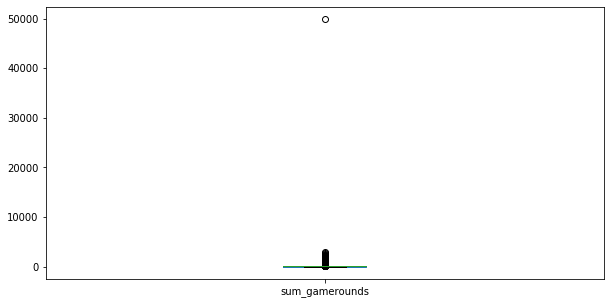

In [12]:
gameData['sum_gamerounds'].plot.box(figsize = (10, 5))

There is an outlier. This player played about 50,000 game rounds during the first week! Due to this outlier, this boxplot is extremely skewed and not very informative.

## We will check the percentiles

In [13]:
gameData['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

## Counting the number of players for each number of gamerounds 

In [14]:
plot_df = gameData.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

## Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game

Text(0.5, 0, 'Number of Game rounds')

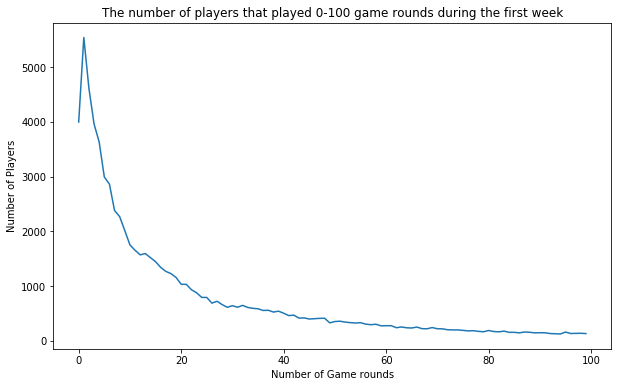

In [16]:
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('Number of Game rounds')

The distribution is highly skewed, with a long tail on the right. A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.

## Comparing 1-day Retention 

In [17]:
gameData['retention_1'].sum() / gameData['retention_1'].count()

0.4452095044850259

A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups

## 1-day retention for each AB-group

In [18]:
gameData.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## Creating an list with bootstrapped means for each AB-group

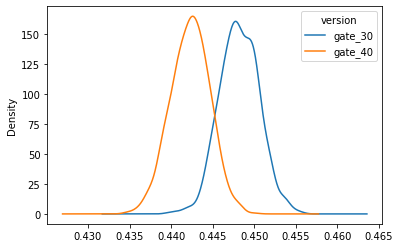

In [19]:
boot_1d = []
for i in range(1000):
    boot_mean = gameData.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind = 'density')

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. 

## Plot the % difference

Probability that 1-day retention is greater when the gate is at level 30: 0.958


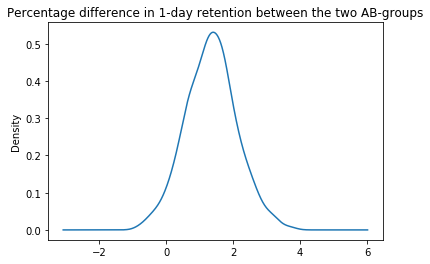

In [21]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('Percentage difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

We can see that the most likely percentage difference is around 1% to 2%, and that 96% of the distribution is above 0%, in favor of a gate at level 30

## Comparing 7-day Retention 

In [22]:
gameData.groupby('version')['retention_7'].sum() / gameData.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

* Like with 1-day retention, 7-day retention is slightly lower when the gate is at level 40 (18.2%) than when the gate is at level 30 (19.0%).
* This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate.
* The overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

## Bootstrap analysis to figure out how certain we should be of the difference between the AB-groups

Probability that 7-day retention is greater when the gate is at level 30: 1.0


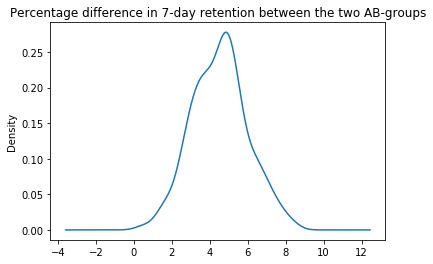

In [23]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = gameData.sample(frac = 1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('Percentage difference in 7-day retention between the two AB-groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:', (boot_7d['diff'] > 0).mean())

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. 

`The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.`